### Trying to reproduce a simple VAE from this tutorial:
#### https://becominghuman.ai/variational-autoencoders-for-new-fruits-with-keras-and-pytorch-6d0cfc4eeabd

#### Dataset can be downloaded here: https://www.kaggle.com/moltean/fruits

In [1]:
%matplotlib inline

## 0. Imports

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import pickle
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [6]:
from keras import applications
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
from keras.layers import Dense, Input, UpSampling2D, Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

## 1. Config

In [7]:
img_width, img_height = 100, 100
train_data_dir = 'data/fruits-360/Training'
validation_data_dir = 'data/fruits-360/Test'
batch_size = 64
nb_epoch = 50
nb_channels = 3

## 2. See data

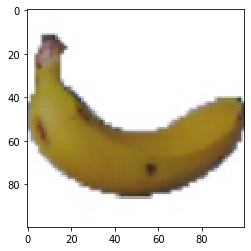

In [8]:
img = plt.imread(f'{train_data_dir}/Banana/66_100.jpg')
plt.imshow(img)

## 3. Model

### 3.1. FC

#### Config

In [6]:
encoding_dim = 256

In [7]:
def flattened_generator(generator):
    for batch in generator:
        yield (batch.reshape(-1,img_width*img_height*nb_channels), batch.reshape(-1,img_width*img_height*nb_channels))

#### Data loaders

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, shuffle=True)

Found 55413 images belonging to 108 classes.
Found 18597 images belonging to 108 classes.


#### Model

In [10]:
def AE_FC():
    input_img = Input(shape=(img_height*img_width*nb_channels,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(img_height*img_width*nb_channels, activation='sigmoid')(encoded)
    return Model(input_img, decoded)

In [11]:
autoencoder = AE_FC()

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               7680256   
_________________________________________________________________
dense_2 (Dense)              (None, 30000)             7710000   
Total params: 15,390,256
Trainable params: 15,390,256
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#### Train

In [14]:
checkpoint = ModelCheckpoint(filepath = "model_weights_ae_fc.h5", save_best_only=True, monitor="val_loss", mode="min" )
history = History()

In [15]:
autoencoder.fit_generator(
    flattened_generator(train_generator),
    samples_per_epoch=math.floor(41322  / batch_size),
    nb_epoch=nb_epoch,
    validation_data=flattened_generator(validation_generator),
    nb_val_samples=math.floor(13877  / batch_size),
    verbose=0,
    callbacks=[history, checkpoint, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

/Users/max.leander/anaconda3/envs/fake-everything/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/Users/max.leander/anaconda3/envs/fake-everything/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=645, epochs=50, validation_steps=216)`
  


KeyboardInterrupt: 

#### Reconstruction sample

In [ ]:
x_test = validation_generator.next()

In [ ]:
decoded_imgs = autoencoder.predict(x_test.reshape(64,30000))

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### History

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.epoch,history.history["val_loss"])
plt.plot(history.epoch,history.history["loss"])
plt.title("Validation loss and loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Validation Loss','Training Loss'],fontsize=14)
plt.show()

In [ ]:
with open("history_fc.pickle","wb") as file:
    pickle.dump(history.history, file)

### 3.2. CNN AE

#### Config

In [ ]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

#### Data loaders

In [ ]:
train_datagen_cnn = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen_cnn = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator_cnn = train_datagen_cnn.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, shuffle=True)

In [ ]:
validation_generator_cnn = test_datagen_cnn.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, shuffle=True)

#### Model

In [ ]:
def AE_CNN():
    input_img = Input(shape=(img_width, img_height, 3))
    
    # Encoding network
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    encoded = Conv2D(32, (2, 2), activation='relu', padding="same", strides=2)(x)

    # Decoding network
    x = Conv2D(32, (2, 2), activation='relu', padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

In [ ]:
checkpoint_cnn = ModelCheckpoint(filepath = "model_weights_ae_cnn.h5", save_best_only=True,monitor="val_loss", mode="min" )
history_cnn = History()

In [ ]:
autoencoder_cnn = AE_CNN()
autoencoder_cnn.compile(optimizer='adadelta', loss='binary_crossentropy')

#### Train

In [ ]:
autoencoder_cnn.fit_generator(
    fixed_generator(train_generator_cnn),
    samples_per_epoch=math.floor(41322  / batch_size),
    nb_epoch=nb_epoch,
    validation_data=fixed_generator(validation_generator_cnn),
    nb_val_samples=math.floor(13877  / batch_size),
    verbose=0,
    callbacks=[history_cnn, checkpoint_cnn, TQDMNotebookCallback(leave_inner=True, leave_outer=True)]
        )

#### Reconstruction sample

In [ ]:
x_test = validation_generator_cnn.next()

In [ ]:
decoded_imgs = autoencoder_cnn.predict(x_test)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### History

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history_cnn.epoch,history_cnn.history["val_loss"])
plt.plot(history_cnn.epoch,history_cnn.history["loss"])
plt.title("Validation loss and loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Validation Loss','Training Loss'],fontsize=14)
plt.show()

In [ ]:
with open("history_cnn.pickle","wb") as file:
    pickle.dump(history_cnn.history, file)